# 1. Importing Libraries

In [33]:
import os
from workalendar.europe import Russia
from datetime import date
import itertools
from src.reformers import group

import numpy as np
from sklearn.ensemble import IsolationForest
from datetime import datetime
import seaborn as sns
from tqdm.notebook import tqdm
from src.helpers import get_project_dir
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn.cluster import DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.metrics import *
import xgboost as xgb
tqdm.pandas()
from sklearn.dummy import DummyRegressor
from src.helpers import eval, custom_score, cross_validate_

import warnings
warnings.filterwarnings("ignore")

# 2. Importing Data

In [2]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/train_data.csv')).rename(columns={'timestamp': 'date'})
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})

In [3]:
# Timestamp -> Datetime
tqdm.pandas()
df['date'] = df['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df = df.sort_values(by='date')
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date')

  0%|          | 0/8526526 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

# 3. Outliers detection

##  3.1. lon & lat (with DBSCAN)

### Initial detection (train set)

In [4]:
points1 = df.drop_duplicates(subset='point')[['point','lon','lat']] \
           .sort_values(by='lon')

 0    7024
-1      17
Name: cluster, dtype: int64


<Axes: xlabel='lon', ylabel='lat'>

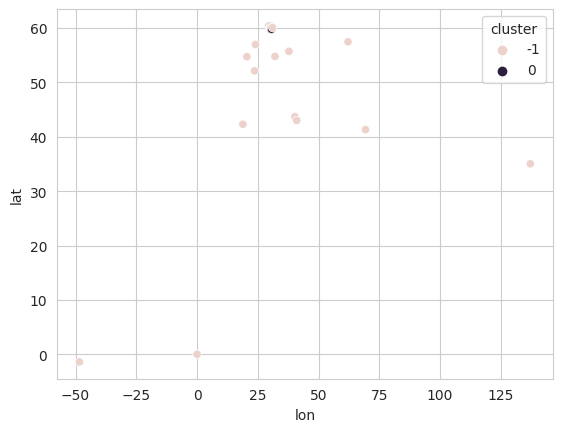

In [5]:
outlier_detection = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 10,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(points1[['lon','lat']])
points1['cluster'] = clusters
print(points1['cluster'].value_counts())

sns.scatterplot(data=points1, x='lon', y='lat', hue='cluster')

<Axes: xlabel='lon', ylabel='lat'>

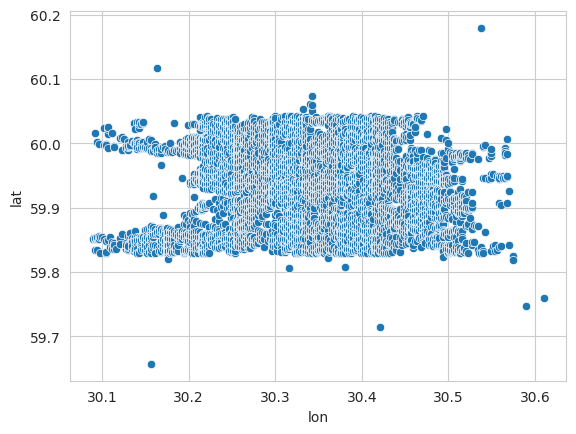

In [6]:
points2 = points1[points1['cluster']==0]
sns.scatterplot(data=points2, x='lon', y='lat')

### Secondary detection (train set)

 0    6950
-1      44
 2      18
 1      12
Name: cluster, dtype: int64


<Axes: xlabel='lon', ylabel='lat'>

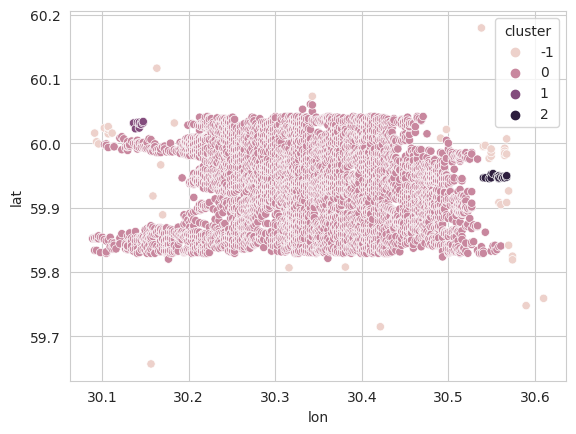

In [7]:
outlier_detection = DBSCAN(
  eps = 0.015,
  metric="euclidean",
  min_samples = 10,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(points2[['lon','lat']])
points2['cluster'] = clusters
print(points2['cluster'].value_counts())

sns.scatterplot(data=points2, x='lon', y='lat', hue='cluster')

<Axes: xlabel='lon', ylabel='lat'>

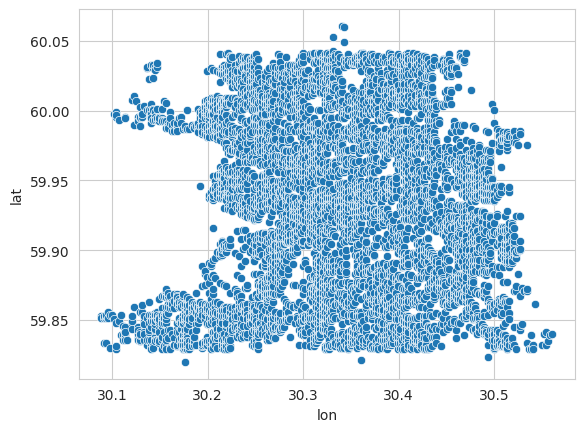

In [11]:
points3 = points2[points2['cluster'].isin([0, 1])]
sns.scatterplot(data=points3, x='lon', y='lat')

In [12]:
print(f'Initial number of points: {len(points1)}')
print(f'Resulting number of points: {len(points3)}')
print(f'Number of outliers: {len(points1) - len(points3)}')
print(f'% of outliers: {round((len(points1) - len(points3))/len(points1)*100,1)}')

Initial number of points: 7041
Resulting number of points: 6962
Number of outliers: 79
% of outliers: 1.1


In [13]:
df2 = df[df['point'].isin(points3['point'])]
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df2)}')
print(f'Number of outliers: {len(df) - len(df2)}')
print(f'% of outliers: {round((len(df) - len(df2))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 8444501
Number of outliers: 82025
% of outliers: 1.0


### Detection in val set

In [14]:
points_v = df_v.drop_duplicates(subset='point')[['point','lon','lat']] \
               .sort_values(by='lon')

 0    154
-1      1
Name: cluster, dtype: int64


<Axes: xlabel='lon', ylabel='lat'>

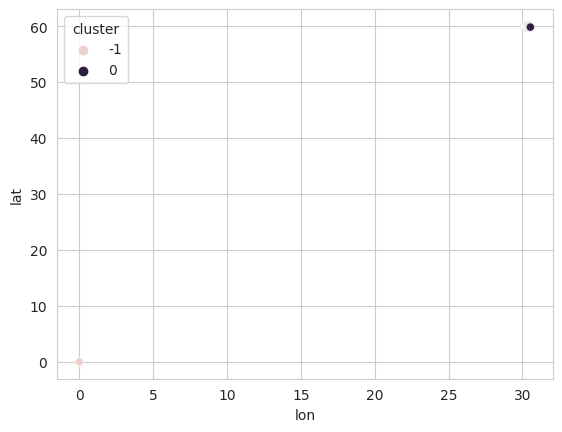

In [15]:
outlier_detection = DBSCAN(
  eps = 0.1,
  metric="euclidean",
  min_samples = 10,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(points_v[['lon','lat']])
points_v['cluster'] = clusters
print(points_v['cluster'].value_counts())

sns.scatterplot(data=points_v, x='lon', y='lat', hue='cluster')

<Axes: xlabel='lon', ylabel='lat'>

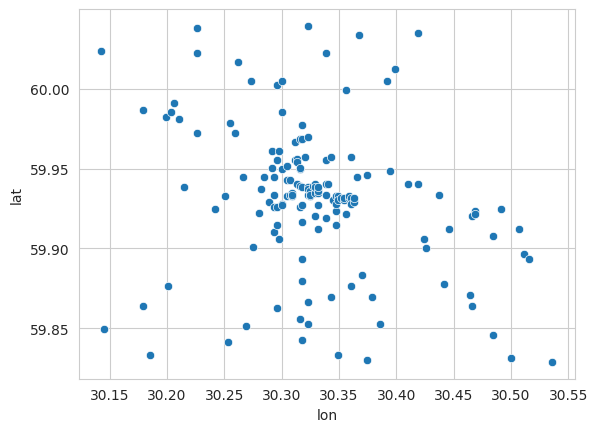

In [16]:
points_v = points_v[points_v['cluster']==0]
sns.scatterplot(data=points_v, x='lon', y='lat')

<Axes: xlabel='lon', ylabel='lat'>

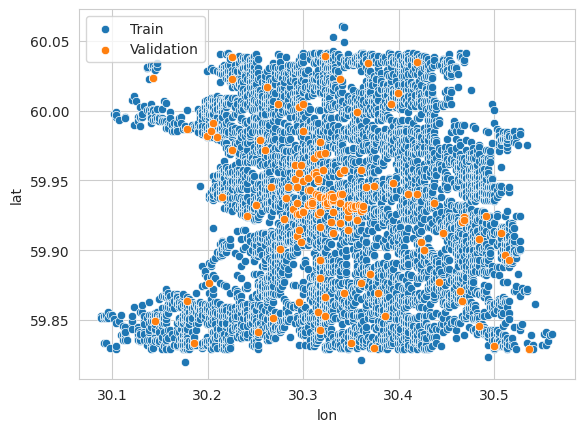

In [17]:
sns.scatterplot(data=points3, x='lon', y='lat', label='Train')
sns.scatterplot(data=points_v, x='lon', y='lat', label='Validation')

## 3.2. Isolation forest

In [18]:
df2

,date,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
5218640,2019-01-01 00:00:00,30.309158,59.941612,72,2,14,2,0,0,0,0,0101000020E6100000268147F5244F3E406DAFAAC186F8...
5218657,2019-01-01 00:00:00,30.329370,59.934863,26,0,0,0,0,0,0,0,0101000020E6100000DBC1F19351543E40DB251193A9F7...
5218656,2019-01-01 00:00:00,30.349582,59.944987,26,0,46,2,3,0,0,7,0101000020E610000091029C327E593E407916A554F5F8...
5218655,2019-01-01 00:00:00,30.226064,59.971970,16,0,37,0,3,0,0,0,0101000020E61000008D938B4CDF393E40F91CC68469FC...
5218654,2019-01-01 00:00:00,30.158690,59.991070,10,0,0,0,0,0,0,0,0101000020E61000002D1154E69F283E4076150862DBFE...
...,...,...,...,...,...,...,...,...,...,...,...,...
2622352,2020-01-31 23:00:00,30.282208,59.906723,4,0,34,3,0,0,0,0,0101000020E6100000328064CC3E483E404D7C7C7F0FF4...
2622351,2020-01-31 23:00:00,30.212589,59.978713,29,1,373,41,0,0,0,4,0101000020E610000013131A386C363E400D42027446FD...
2622350,2020-01-31 23:00:00,30.336107,59.931487,17,0,596,31,30,1,0,2,0101000020E610000019822A1E0B563E40CAE971F73AF7...
2622358,2020-01-31 23:00:00,30.327124,59.935988,56,0,29,4,0,0,0,0,0101000020E61000001CD7DE65BE533E40E4A1F770CEF7...


In [26]:
feats = ['lon', 'lat', 'likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']
clf = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1).fit(df2[feats])

In [27]:
df2['is_not_outlier'] = clf.predict(df2[feats])

In [28]:
df2['is_not_outlier'].value_counts()

 1    7552170
-1     892331
Name: is_not_outlier, dtype: int64

In [29]:
df3 = df2[df2['is_not_outlier']==1].drop('is_not_outlier', axis=1)
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df3)}')
print(f'Number of outliers: {len(df) - len(df3)}')
print(f'% of outliers: {round((len(df) - len(df3))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 7552170
Number of outliers: 974356
% of outliers: 11.4


# 4. Aggregating data

## Train set

In [45]:
df4 = group(df3)
df4

,point,date,likescount_sum,count,commentscount_sum,symbols_cnt_sum,words_cnt_sum,hashtags_cnt_sum,mentions_cnt_sum,links_cnt_sum,emoji_cnt_sum,lon_mean,lat_mean
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-22 12:00:00,37,1,4,358,31,4,0,0,1,30.116020,59.835705
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-23 13:00:00,34,1,0,119,7,4,0,0,0,30.116020,59.835705
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-27 10:00:00,42,1,2,242,18,4,0,0,1,30.116020,59.835705
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-30 10:00:00,43,1,2,207,17,4,0,0,0,30.116020,59.835705
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-12-01 12:00:00,22,1,0,247,20,4,0,0,1,30.116020,59.835705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295195,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,2019-09-09 04:00:00,141,1,1,108,10,0,0,0,4,30.522508,59.898840
3295196,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,2019-12-06 04:00:00,6,2,0,51,6,0,0,0,2,30.522508,59.898840
3295197,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,2019-06-10 09:00:00,40,1,1,96,5,1,0,0,1,30.522508,59.870670
3295198,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,2019-10-06 14:00:00,26,1,0,0,0,0,0,0,0,30.522508,59.870670


In [ ]:
df4.to_csv(os.path.join(get_project_dir(), 'data/train_data2.csv'), index=False)

# 5. Feature Engineering

## Time based features

In [5]:
country = Russia()
holidays = [item[0] for item in country.holidays(2019)] + [item[0] for item in country.holidays(2020)]
weather = pd.read_excel(os.path.join(get_project_dir(), 'data/weather_spb.xlsx'))
weather = dict([(a, b) for (a,b) in zip(weather['date'], weather['day_temp'])])
def f(x):
    output_ = [x.hour,
               x.day,
               x.month,
               x.year,
              1 if (x.hour >= 23) and (x.hour < 7) else 0,
              1 if (x.hour >= 19) and (x.hour < 23) else 0,
              1 if (x.hour >= 7) and (x.hour < 9) else 0,
              1 if (x.hour >= 9) and (x.hour < 19) else 0,
              x.weekday(),
              1 if x.weekday() in [5, 6] else 0,
              1 if date(x.year, x.month, x.day) in holidays else 0,
              1 if country.is_working_day(date(x.year, x.month, x.day)) else 0,
              weather[pd.Timestamp(year=x.year, month=x.month, day=x.day)]]
    return output_

### Train

In [3]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/train_data2.csv')).drop('Unnamed: 0', axis=1)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df['date'] = df['date'].astype('datetime64')
df['new'] = df['date'].progress_apply(lambda x: f(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df[feats] = pd.DataFrame(df['new'].tolist(), index=df.index)
df = df.drop('new', axis=1) \
       .rename(columns={'lon_mean': 'lon', 'lat_mean': 'lat'})

In [50]:
df.to_csv(os.path.join(get_project_dir(), 'data/train_data3.csv'))

### Val

In [2]:
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date')

  0%|          | 0/709 [00:00<?, ?it/s]

In [6]:
df_v['date'] = df_v['date'].astype('datetime64')
df_v['new'] = df_v['date'].progress_apply(lambda x: f(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df_v[feats] = pd.DataFrame(df_v['new'].tolist(), index=df_v.index)
df_v = df_v.drop('new', axis=1)

  0%|          | 0/709 [00:00<?, ?it/s]

# 6. Feature Generation

In [7]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d1/train_data3.csv')).drop('Unnamed: 0', axis=1)

## Generating features in val set based on train set

In [8]:
df_lag = df.groupby(['point', 'hour', 'month', 'weekday'], as_index=False) \
             .agg({'likescount_sum': 'mean',
                   'commentscount_sum': 'mean',
                   'symbols_cnt_sum': 'mean',
                   'mentions_cnt_sum': 'mean',
                   'links_cnt_sum': 'mean',
                   'emoji_cnt_sum': 'mean',
                   'words_cnt_sum': 'mean',
                   'hashtags_cnt_sum': 'mean'})

In [9]:
df_v = df_v.merge(df_lag, how='left')

# 7. Dummy Regressor

In [37]:
target = 'count'
eval(DummyRegressor(strategy="mean"), df, df_v, ['lat'], 'count')

train R2 = 0.0
train custom = 0.7452679337401568
val R2 = -1.4043376858955816
val custom = 3.3109394801523644


# 8. XGBoost

In [35]:
## Only lan, lot, temp and time-based features
feats = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
         'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
scores = cross_validate_(model=xgb.XGBRegressor, params=params, X=df[feats], y=df[target], cv=5,
                         scoring={'R2': r2_score, 'custom': custom_score}, random_state=42)

train cv R2 = 0.43798781625225447
train cv custom = 0.6762804134967257


In [17]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, feats, target)

train R2 = 0.44258744605101485
train custom = 0.30752653721137563
val R2 = -0.19238892809005237
val custom = 1.555368153193089


## All features

In [38]:
feats = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']

In [40]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
scores = cross_validate_(model=xgb.XGBRegressor, params=params, X=df[feats], y=df[target], cv=5,
                         scoring={'R2': r2_score, 'custom': custom_score}, random_state=42)

train cv R2 = 0.8696018777433496
train cv custom = 0.2656165045970401


In [41]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, feats, target)

train R2 = 0.8896198484943149
train custom = 0.27543733224727196
val R2 = -306.30244672573525
val custom = 1.7422043512742735


# 8. Feature selection (permutation importance)

## lat, lon, temp and time-based feats

In [45]:
feats = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
         'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [46]:
r = permutation_importance(model, df_v[feats], df_v['sum'], n_repeats=50, random_state=42)

In [47]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

,feat,importance
0,lon,0.948612
1,lat,0.924997
2,hour,0.123114
13,is_working_day,0.013409
12,is_holiday,0.005814
9,is_day,0.003658
4,month,0.000000
5,year,0.000000
6,is_night,0.000000
7,is_evening,0.000000


In [50]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:], target)

train R2 = 0.44258744605101485
train custom = 0.30752653721137563
val R2 = -0.1955443043651861
val custom = 1.5616747629056174


In [49]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:11], target)

train R2 = 0.4410692468203493
train custom = 0.5228229353237646
val R2 = -0.17162775057647361
val custom = 1.4232057534742237


In [52]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:8], target)

train R2 = 0.4348766429142721
train custom = -14.599989245805741
val R2 = -0.14757145924996018
val custom = 1.4420894561030513


In [51]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:6], target)

train R2 = 0.4025950949039332
train custom = 0.5367093306281412
val R2 = -0.31742234659524504
val custom = 1.7216075338468835


## All features

In [14]:
feats = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
r = permutation_importance(model, df_v[feats], df_v['sum'], n_repeats=50, random_state=42)

In [19]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

,feat,importance
10,hour,3.526460
9,lat,0.931976
11,day,0.341052
22,temp,0.251665
13,year,0.000000
12,month,0.000000
19,is_weekend,0.000000
14,is_night,0.000000
16,is_morning,0.000000
20,is_holiday,-0.000134


In [42]:
top_feats = imps['feat'].tolist()[:20]
top_feats

['hour',
 'lat',
 'day',
 'temp',
 'year',
 'month',
 'is_weekend',
 'is_night',
 'is_morning',
 'is_holiday',
 'is_working_day',
 'is_evening',
 'is_day',
 'weekday',
 'links_cnt_sum',
 'words_cnt_sum',
 'lon',
 'symbols_cnt_sum',
 'hashtags_cnt_sum',
 'emoji_cnt_sum']

In [44]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, feats, target)

train R2 = 0.8896198484943149
train custom = 0.27543733224727196
val R2 = -306.30244672573525
val custom = 1.7422043512742735


In [43]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, top_feats, target)

train R2 = 0.8136887922473888
train custom = 0.3570167039114793
val R2 = -54.98525911689498
val custom = 2.0834621317884436


In [41]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, top_feats, target)

train R2 = 0.16317674662583803
train custom = 0.5222914696131895
val R2 = -0.890896945718018
val custom = 1.9416422665705415


In [39]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, top_feats, target)

train R2 = 0.11815514177409525
train custom = 0.5810949094546451
val R2 = -1.0449812397504035
val custom = 2.4357663648166508


In [37]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
eval(xgb.XGBRegressor(**params), df, df_v, top_feats, target)

train R2 = 0.14413042833206458
train custom = 0.5894791522749687
val R2 = -0.8015520750052143
val custom = 1.957721724126471


# Some plots

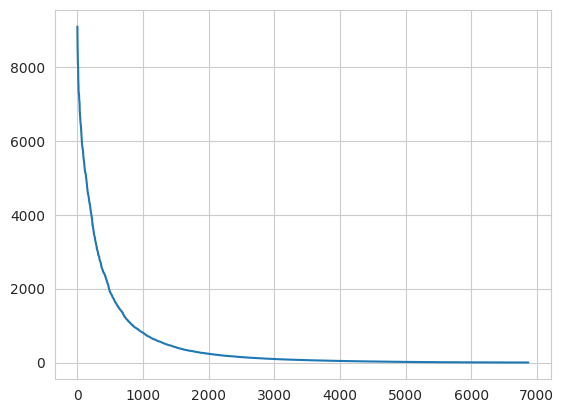

In [40]:
plt.plot(df.groupby('point').count().sort_values(by='date', ascending=False)['date'].values)